# Image Generation with Stable Diffusion and IP-Adapter

[IP-Adapter](https://hf.co/papers/2308.06721) is an effective and lightweight adapter that adds image prompting capabilities to a diffusion model. This adapter works by decoupling the cross-attention layers of the image and text features. All the other model components are frozen and only the embedded image features in the UNet are trained. As a result, IP-Adapter files are typically only ~100MBs.
![ip-adapter-pipe.png](https://huggingface.co/h94/IP-Adapter/resolve/main/fig1.png)

In this tutorial, we will consider how to convert and run Stable Diffusion pipeline with loading IP-Adapter. We will use [stable-diffusion-v1.5](https://huggingface.co/runwayml/stable-diffusion-v1-5) as base model and apply official [IP-Adapter](https://huggingface.co/h94/IP-Adapter) weights. Also for speedup generation process we will use [LCM-LoRA](https://huggingface.co/latent-consistency/lcm-lora-sdv1-5)
#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Prepare Diffusers pipeline](#Prepare-Diffusers-pipeline)
- [Convert PyTorch models](#Convert-PyTorch-models)
    - [Image Encoder](#Image-Encoder)
    - [U-net](#U-net)
    - [VAE Encoder and Decoder](#VAE-Encoder-and-Decoder)
    - [Text Encoder](#Text-Encoder)
- [Prepare OpenVINO inference pipeline](#Prepare-OpenVINO-inference-pipeline)
- [Run model inference](#Run-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Generation image variation](#Generation-image-variation)
    - [Generation conditioned by image and text](#Generation-conditioned-by-image-and-text)
    - [Generation image blending](#Generation-image-blending)
- [Interactive demo](#Interactive-demo)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)
## Prerequisites

In [1]:
%pip uninstall -y -q openvino-dev openvino openvino-nightly
%pip install -q torch transformers diffusers openvino-nightly gradio matplotlib --extra-index-url https://download.pytorch.org/whl/cpu

## Prepare Diffusers pipeline
[back to top ⬆️](#Table-of-contents:)

First of all, we should collect all componets of our pipeline together. To work with Stable Diffusion, we will use HuggingFace [Diffusers](https://github.com/huggingface/diffusers) library. To experiment with Stable Diffusion models, Diffusers exposes the [`StableDiffusionPipeline`](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview). Additionally, the pipeline supports load adapters that extend Stable Diffusion functionality such as [Low-Rank Adaptation (LoRA)](https://huggingface.co/papers/2106.09685), [PEFT](https://huggingface.co/docs/diffusers/main/en/tutorials/using_peft_for_inference), [IP-Adapter](https://ip-adapter.github.io/), and [Textual Inversion](https://textual-inversion.github.io/). You can find more information about supported adapters in [diffusers documentation](https://huggingface.co/docs/diffusers/main/en/using-diffusers/loading_adapters).

In this tutorial, we will focus on ip-adapter. IP-Adapter can be integrated into diffusion pipeline using `load_ip_adapter` method. IP-Adapter allows you to use both image and text to condition the image generation process. For adjusting the text prompt and image prompt condition ratio, we can use `set_ip_adapter_scale()` method. If you only use the image prompt, you should set the scale to 1.0. You can lower the scale to get more generation diversity, but it’ll be less aligned with the prompt. scale=0.5 can achieve good results when you use both text and image prompts.

As discussed before, we will also use LCM LoRA for speeding generation process. You can find more information about LCM LoRA in this [notebook](notebooks/263-latent-consistency-models-image-generation/263-lcm-lora-controlnet.ipynb). For applying LCM LoRA, we should use `load_lora_weights` method. Additionally, LCM requires using LCMScheduler for efficient generation.

In [2]:
from pathlib import Path
from diffusers import StableDiffusionPipeline
from diffusers.utils import load_image
from diffusers import LCMScheduler


stable_diffusion_id = "runwayml/stable-diffusion-v1-5"
ip_adapter_id = "h94/IP-Adapter"
ip_adapter_weight_name = "ip-adapter_sd15.bin"
lcm_lora_id = "latent-consistency/lcm-lora-sdv1-5"
models_dir = Path("model")

load_original_pipeline = not all([(models_dir / model_name).exists() for model_name in ["text_encoder.xml", "image_encoder.xml", "unet.xml", "vae_decoder.xml", "vae_encoder.xml"]])

def get_pipeline_components(stable_diffusion_id, ip_adapter_id, ip_adapter_weight_name , lcm_lora_id, ip_adapter_scale=0.6):
    pipeline = StableDiffusionPipeline.from_pretrained(stable_diffusion_id)
    pipeline.load_lora_weights(lcm_lora_id)
    pipeline.fuse_lora()
    pipeline.load_ip_adapter(ip_adapter_id, subfolder="models", weight_name=ip_adapter_weight_name)
    pipeline.set_ip_adapter_scale(0.6)
    scheduler = LCMScheduler.from_pretrained(stable_diffusion_id, subfolder="scheduler")
    return pipeline.tokenizer, pipeline.feature_extractor, scheduler, pipeline.text_encoder, pipeline.image_encoder, pipeline.unet, pipeline.vae

if load_original_pipeline:
    tokenizer, feature_extractor, scheduler, text_encoder, image_encoder, unet, vae = get_pipeline_components(stable_diffusion_id, ip_adapter_id, ip_adapter_weight_name, lcm_lora_id)
    scheduler.save_pretrained(models_dir / "scheduler")
else:
    tokenizer, feature_extractor, scheduler, text_encoder, image_encoder, unet, vae = None, None, None, None, None, None, None

2024-01-23 11:32:31.966784: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 11:32:32.008335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 11:32:32.774920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Convert PyTorch models
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Image Encoder to create image condition for IP-Adapter.
* Text Encoder to create condition to generate an image from a text prompt.
* U-Net for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:

### Image Encoder
[back to top ⬆️](#Table-of-contents:)

IP-Adapter relies on an image encoder to generate the image features. Usually [`CLIPVisionModelWithProjection`](https://huggingface.co/docs/transformers/main/en/model_doc/clip#transformers.CLIPVisionModelWithProjection) is used as Image Encoder. For preprocessing input image, Image Encoder uses `CLIPImageProcessor` named feature extractor in pipeline. The image encoder accept resized and normalized image processed by feature extractor as input and returns image embeddings.

In [3]:
import openvino as ov
import torch
import gc

def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

IMAGE_ENCODER_PATH = models_dir / "image_encoder.xml"

if not IMAGE_ENCODER_PATH.exists():
    with torch.no_grad():
        ov_model = ov.convert_model(image_encoder, example_input=torch.zeros((1, 3, 224, 224)), input=[-1,3,224,224])
    ov.save_model(ov_model, IMAGE_ENCODER_PATH)
    feature_extractor.save_pretrained(models_dir / "feature_extractor")
    del ov_model
    cleanup_torchscript_cache()

del image_encoder
del feature_extractor

gc.collect();

### U-net
[back to top ⬆️](#Table-of-contents:)

U-Net model gradually denoises latent image representation guided by text encoder hidden state.

Generally, U-Net model conversion process remain the same like in Stable Diffusion, expect additional input that accept image embeddings generted by Image Encoder. In Stable Diffusion pipeline, this data provided into model using dictionary `added_cond_kwargs` and key `image_embeds` inside it. After OpenVINO conversion, this input will be decomposed from dictionary. In some cases, such decomposition may lead to loosing information about input shape and data type. We can restore it manually as demonstrated in the code bellow.

U-Net model inputs:

* `sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
* `timestep` - current scheduler step.
* `encoder_hidden_state` - hidden state of text encoder.
* `image_embeds` - hidden state of image encoder.

Model predicts the `sample` state for the next step.

In [4]:
UNET_PATH = models_dir / "unet.xml"


if not UNET_PATH.exists():
    inputs = {
        "sample": torch.randn((2, 4, 64, 64)),
        "timestep": torch.tensor(1),
        "encoder_hidden_states": torch.randn((2,77,768)),
        "added_cond_kwargs": {"image_embeds": torch.ones((2, 1024))}
    }

    with torch.no_grad():
        ov_model = ov.convert_model(unet, example_input=inputs)
    # dictionary with added_cond_kwargs will be decomposed during conversion
    # in some cases decomposition may lead to losing data type and shape information
    # We need to recover it manually after the conversion
    ov_model.inputs[-1].get_node().set_element_type(ov.Type.f32)
    ov_model.validate_nodes_and_infer_types()
    ov.save_model(ov_model, UNET_PATH)
    del ov_model
    cleanup_torchscript_cache()

del unet

gc.collect();

### VAE Encoder and Decoder
[back to top ⬆️](#Table-of-contents:)

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. When you run inference for Text-to-Image, there is no initial image as a starting point. You can skip this step and directly generate initial random noise. VAE encoder is used in Image-to-Image generation pipelines for creating initial latent state based on input image. The main difference between IP-Adapter encoded image and VAE encoded image that the first is used as addition into input prompt making connection between text and image during conditioning, while the second used as Unet sample initialization and does not give guarantee preserving some attributes of initial image. It is still can be useful to use both ip-adpater and VAE image in pipeline, we can discuss it in inference examples.

In [5]:
VAE_DECODER_PATH = models_dir / "vae_decoder.xml"
VAE_ENCODER_PATH = models_dir / "vae_encoder.xml"

if not VAE_DECODER_PATH.exists():
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae
    
        def forward(self, latents):
            return self.vae.decode(latents)

    vae_decoder = VAEDecoderWrapper(vae)
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=torch.ones([1,4,64,64]))
    ov.save_model(ov_model, VAE_DECODER_PATH)
    del ov_model
    cleanup_torchscript_cache()
    del vae_decoder

if not VAE_ENCODER_PATH.exists():
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(x=image)["latent_dist"].sample()
    vae_encoder = VAEEncoderWrapper(vae)
    vae_encoder.eval()
    image = torch.zeros((1, 3, 512, 512))
    with torch.no_grad():
        ov_model = ov.convert_model(vae_encoder, example_input=image)
    ov.save_model(ov_model, VAE_ENCODER_PATH)
    del ov_model
    cleanup_torchscript_cache()

del vae

gc.collect();

### Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

The input of the text encoder is tensor `input_ids`, which contains indexes of tokens from text processed by the tokenizer and padded to the maximum length accepted by the model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - pooled output for whole model hidden states.

In [6]:
TEXT_ENCODER_PATH = models_dir / "text_encoder.xml"

if not TEXT_ENCODER_PATH.exists():
    with torch.no_grad():
        ov_model = ov.convert_model(text_encoder, example_input=torch.ones([1,77], dtype=torch.long), input=[(1,77),])
    ov.save_model(ov_model, TEXT_ENCODER_PATH)
    del ov_model
    cleanup_torchscript_cache()
    tokenizer.save_pretrained(models_dir / "tokenizer")

del text_encoder
del tokenizer

## Prepare OpenVINO inference pipeline
[back to top ⬆️](#Table-of-contents:)

As shown on diagram below, the only difference between original Stable Diffusion pipeline  and IP-Adapter Stable Diffusion pipeline only in additional conditioning by image processed via Image Encoder. 
![pipeline.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/1afc2ca6-e7ea-4c9e-a2d3-1173346dd9d6)

The stable diffusion model with ip-adapter takes  a latent image representation, a text prompt is transformed to text embeddings via CLIP text encoder and ip-adapter image is transformed to image embeddings via CLIP Image Encoder. Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text and image embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm.

The *denoising* process is repeated given number of times (by default 4 taking into account that we use LCM) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder (VAE).

In [7]:
import inspect
from typing import List, Optional, Union, Dict, Tuple
import numpy as np

import PIL
import cv2
import torch

from transformers import CLIPTokenizer, CLIPImageProcessor
from diffusers import DiffusionPipeline
from diffusers.pipelines.stable_diffusion.pipeline_output import StableDiffusionPipelineOutput
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def randn_tensor(
    shape: Union[Tuple, List],
    generator: Optional[Union[List["torch.Generator"], "torch.Generator"]] = None,
    dtype: Optional["torch.dtype"] = None,
):
    """A helper function to create random tensors on the desired `device` with the desired `dtype`. When
    passing a list of generators, you can seed each batch size individually.
    
    """
    batch_size = shape[0]
    rand_device = torch.device("cpu")

    # make sure generator list of length 1 is treated like a non-list
    if isinstance(generator, list) and len(generator) == 1:
        generator = generator[0]

    if isinstance(generator, list):
        shape = (1,) + shape[1:]
        latents = [
            torch.randn(shape, generator=generator[i], device=rand_device, dtype=dtype)
            for i in range(batch_size)
        ]
        latents = torch.cat(latents, dim=0)
    else:
        latents = torch.randn(shape, generator=generator, device=rand_device, dtype=dtype)

    return latents

def preprocess(image: PIL.Image.Image, height, width):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       meta (Dict): dictionary with preprocessing metadata info
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        height, width, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = width - dst_width
    pad_height = height - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}

class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: ov.Model,
        text_encoder: ov.Model,
        tokenizer: CLIPTokenizer,
        unet: ov.Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        image_encoder: ov.Model,
        feature_extractor: CLIPImageProcessor,
        vae_encoder: ov.Model
    ):
        """
        Pipeline for text-to-image generation using Stable Diffusion and IP-Adapter with OpenVINO
        Parameters:
            vae_decoder (ov.Model):
                Variational Auto-Encoder (VAE) Model to decode images to and from latent representations.
            text_encoder (ov.Model):CLIPImageProcessor
                Frozen text-encoder. Stable Diffusion uses the text portion of
                [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
                the clip-vit-large-patch14(https://huggingface.co/openai/clip-vit-large-patch14) variant.
            tokenizer (CLIPTokenizer):
                Tokenizer of class CLIPTokenizer(https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
            unet (ov.Model): Conditional U-Net architecture to denoise the encoded image latents.
            scheduler (SchedulerMixin):
                A scheduler to be used in combination with unet to denoise the encoded image latents
            image_encoder (ov.Model):
                IP-Adapter image encoder for embedding input image as input prompt for generation
            feature_extractor : 
        """
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.unet = unet
        self.height = 512
        self.width = 512
        self.vae_scale_factor = 8
        self.tokenizer = tokenizer
        self.vae_encoder = vae_encoder
        self.feature_extractor = feature_extractor

    def __call__(
        self,
        prompt: Union[str, List[str]],
        ip_adapter_image: PIL.Image.Image,
        image: PIL.Image.Image = None,
        num_inference_steps: Optional[int] = 4,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: Optional[float] = 0.5,
        eta: Optional[float] = 0.0,
        output_type: Optional[str] = "pil",
        height: Optional[int] = None,
        width: Optional[int] = None,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        strength: float = 1.,
        **kwargs,
    ):
        """
        Function invoked when calling the pipeline for generation.
        Parameters:
            prompt (str or List[str]):
                The prompt or prompts to guide the image generation.
            image (PIL.Image.Image, *optional*, None):
                 Intinal image for generation.
            num_inference_steps (int, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            negative_prompt (str or List[str]):https://user-images.githubusercontent.com/29454499/258651862-28b63016-c5ff-4263-9da8-73ca31100165.jpeg
                The negative prompt or prompts to guide the image generation.
            guidance_scale (float, *optional*, defaults to 7.5):
                Guidance scale as defined in Classifier-Free Diffusion Guidance(https://arxiv.org/abs/2207.12598).
                guidance_scale is defined as `w` of equation 2.
                Higher guidance scale encourages to generate images that are closely linked to the text prompt,
                usually at the expense of lower image quality.
            eta (float, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [DDIMScheduler], will be ignored for others.
            output_type (`str`, *optional*, defaults to "pil"):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): PIL.Image.Image or np.array.
            height (int, *optional*, 512): 
                Generated image height
            width (int, *optional*, 512):
                Generated image width
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor is generated by sampling using the supplied random `generator`.
        Returns:
            Dictionary with keys: 
                sample - the last generated image PIL.Image.Image or np.arrayhttps://huggingface.co/latent-consistency/lcm-lora-sdv1-5
                iterations - *optional* (if gif=True) images for all diffusion steps, List of PIL.Image.Image or np.array.
        """
        do_classifier_free_guidance = guidance_scale > 1.0
        # get prompt text embeddings
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)
        # get ip-adapter image embeddings
        image_embeds, negative_image_embeds = self.encode_image(ip_adapter_image)
        if do_classifier_free_guidance:
            image_embeds = np.concatenate([negative_image_embeds, image_embeds])
        
        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength)
        latent_timestep = timesteps[:1]

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(1, 4, height or self.height, width or self.width, generator=generator, latents=latents, image=image, latent_timestep=latent_timestep)

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps)):
            # expand the latents if you are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet([latent_model_input, t, text_embeddings, image_embeds])[0]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()

        # scale and decode the image latents with vae
        image = self.vae_decoder(latents * (1 / 0.18215))[0]

        image = self.postprocess_image(image, meta, output_type)
        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=False)
    
    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded.
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[0]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier-free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings


    def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype=torch.float32, generator=None, latents=None, image=None, latent_timestep=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = randn_tensor(shape, generator=generator, dtype=dtype)

        if image is None:
            # scale the initial noise by the standard deviation required by the scheduler
            latents = latents * self.scheduler.init_noise_sigma
            return latents.numpy(), {}
        input_image, meta = preprocess(image, height, width)
        image_latents = self.vae_encoder(input_image)[0]
        image_latents = image_latents * 0.18215
        latents = self.scheduler.add_noise(torch.from_numpy(image_latents), latents, latent_timestep).numpy()
        return latents, meta
        

    def postprocess_image(self, image:np.ndarray, meta:Dict, output_type:str = "pil"):
        """
        Postprocessing for decoded image. Takes generated image decoded by VAE decoder, unpad it to initial image size (if required), 
        normalize and convert to [0, 255] pixels range. Optionally, converts it from np.ndarray to PIL.Image format
        
        Parameters:
            image (np.ndarray):
                Generated image
            meta (Dict):
                Metadata obtained on the latents preparing step can be empty
            output_type (str, *optional*, pil):
                Output format for result, can be pil or numpy
        Returns:
            image (List of np.ndarray or PIL.Image.Image):
                Post-processed images
        """
        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image

    def encode_image(self, image, num_images_per_prompt=1):
        if not isinstance(image, torch.Tensor):
            image = self.feature_extractor(image, return_tensors="pt").pixel_values

        image_embeds = self.image_encoder(image)[0]
        if num_images_per_prompt > 1:
            image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0)

        uncond_image_embeds = np.zeros(image_embeds.shape)
        return image_embeds, uncond_image_embeds

    def get_timesteps(self, num_inference_steps:int, strength:float):
        """
        Helper function for getting scheduler timesteps for generation
        In case of image-to-image generation, it updates number of steps according to strength
        
        Parameters:
           num_inference_steps (int):
              number of inference steps for generation
           strength (float):
               value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. 
               Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.
        """
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start

## Run model inference
[back to top ⬆️](#Table-of-contents:)

Now let's configure our pipeliner and take a look on generation results.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select inference device from dropdown list.

In [8]:
core = ov.Core()

import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='CPU')

In [9]:
from transformers import AutoTokenizer

ov_config = {"INFERENCE_PRECISION_HINT": "f32"} if device.value != "CPU" else {}
vae_decoder = core.compile_model(VAE_DECODER_PATH, device.value, ov_config)
vae_encoder = core.compile_model(VAE_ENCODER_PATH, device.value, ov_config)
text_encoder = core.compile_model(TEXT_ENCODER_PATH, device.value)
image_encoder = core.compile_model(IMAGE_ENCODER_PATH, device.value)
unet = core.compile_model(UNET_PATH, device.value)

scheduler = LCMScheduler.from_pretrained(models_dir / "scheduler")
tokenizer = AutoTokenizer.from_pretrained(models_dir / "tokenizer")
feature_extractor =  CLIPImageProcessor.from_pretrained(models_dir / "feature_extractor")

ov_pipe =  OVStableDiffusionPipeline(vae_decoder, text_encoder, tokenizer, unet, scheduler, image_encoder, feature_extractor, vae_encoder)

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


### Generation image variation
[back to top ⬆️](#Table-of-contents:)

If we stay input text prompt empty and provide only ip-adapter image, we can get variation of the same image.

In [10]:
import matplotlib.pyplot as plt


def visualize_results(images, titles):
    """
    Helper function for results visualization
    
    Parameters:
       orig_img (PIL.Image.Image): original image
       processed_img (PIL.Image.Image): processed image after editing
       img1_title (str): title for the image on the left
       img2_title (str): title for the image on the right
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    im_w, im_h = images[0].size
    is_horizontal = im_h <= im_w
    figsize = (10, 15 * len(images)) if is_horizontal else (15 * len(images), 10)
    fig, axs = plt.subplots(1 if is_horizontal else len(images), len(images) if is_horizontal else 1, figsize=figsize, sharex='all', sharey='all')
    fig.patch.set_facecolor('white')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    for image, title, ax in zip(images, titles, list_axes):
        ax.imshow(np.array(image))
        ax.set_title(title, fontsize=20) 
    fig.subplots_adjust(wspace=0.0 if is_horizontal else 0.01 , hspace=0.01 if is_horizontal else 0.0)
    fig.tight_layout()
    return fig

  0%|          | 0/4 [00:00<?, ?it/s]

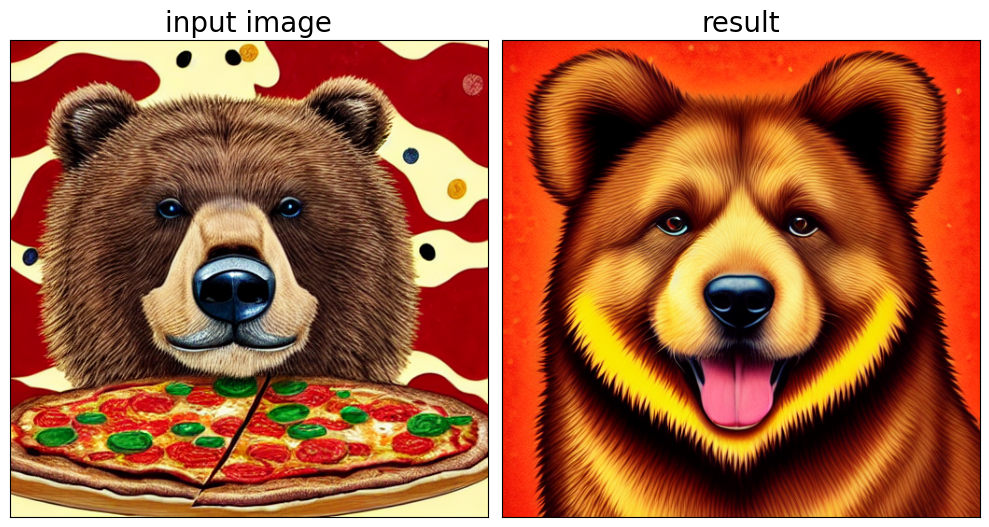

In [11]:
from IPython.display import display

generator = torch.Generator(device="cpu").manual_seed(576)

image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/load_neg_embed.png")

result = ov_pipe(prompt='', 
    ip_adapter_image=image,
    gaidance_scale=1,
    negative_prompt="", 
    num_inference_steps=4,
    generator=generator)

fig = visualize_results([image, result.images[0]], ["input image", "result"])

### Generation conditioned by image and text
[back to top ⬆️](#Table-of-contents:)

IP-Adapter allows you to use both image and text to condition the image generation process. Both IP-Adapter image and text prompt serve as extension for each other, for example we can use a text prompt to add “sunglasses” 😎 on previous image.

In [12]:
generator = torch.Generator(device="cpu").manual_seed(576)

result = ov_pipe(prompt='best quality, high quality, wearing sunglasses', 
    ip_adapter_image=image,
    gaidance_scale=1,
    negative_prompt="monochrome, low-res, bad anatomy, worst quality, low quality", 
    num_inference_steps=4,
    generator=generator)

  0%|          | 0/4 [00:00<?, ?it/s]

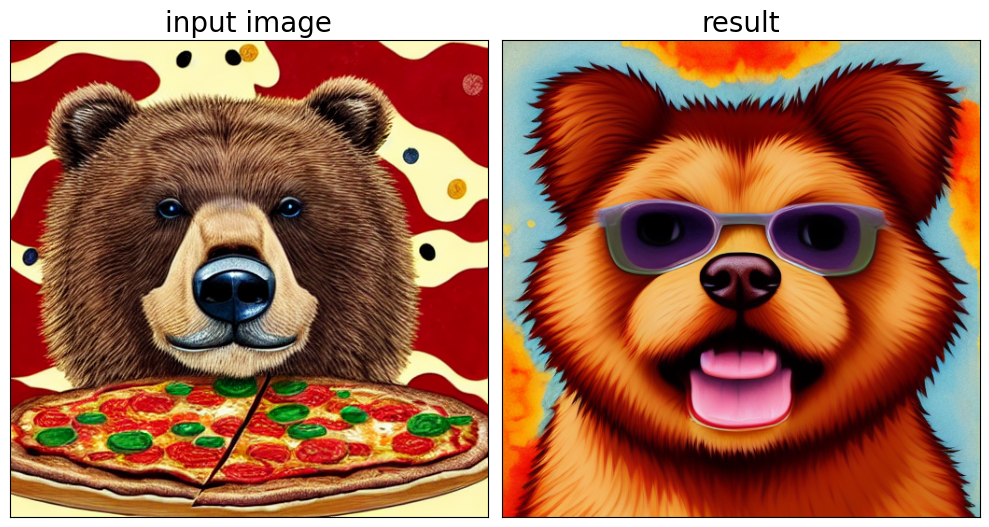

In [13]:
fig = visualize_results([image, result.images[0]], ["input image", "result"])

### Generation image blending
[back to top ⬆️](#Table-of-contents:)

IP-Adapter also works great with Image-to-Image translation. It helps to achive image blending effect.

In [14]:
image = load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/vermeer.jpg")
ip_image = load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/river.png")

result = ov_pipe(prompt='best quality, high quality', 
    image = image,
    ip_adapter_image=ip_image, gaidance_scale=1, generator=generator, strength=0.7, num_inference_steps=8)

  0%|          | 0/5 [00:00<?, ?it/s]

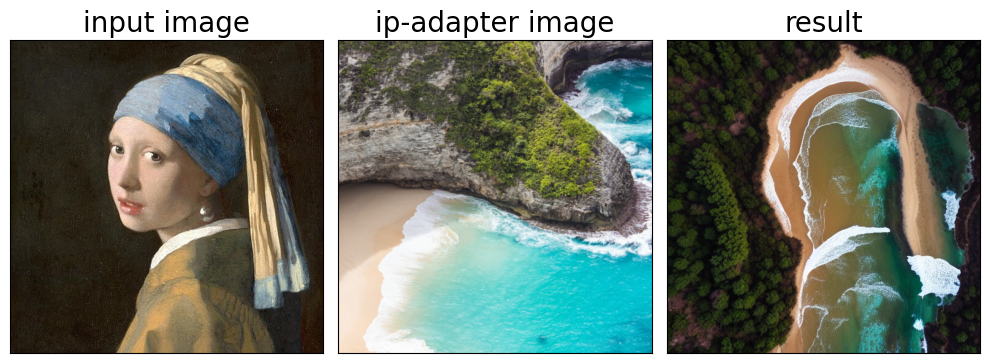

In [15]:
fig = visualize_results([image, ip_image, result.images[0]], ["input image", "ip-adapter image", "result"])

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

Now, you can try model using own images and text prompts.

In [ ]:
import gradio as gr

def generate_from_text(positive_prompt, negative_prompt, ip_adapter_image, seed, num_steps, guidance_scale, _=gr.Progress(track_tqdm=True)):
    generator = torch.Generator(device="cpu").manual_seed(seed)
    result = ov_pipe(positive_prompt, ip_adapter_image=ip_adapter_image, negative_prompt=negative_prompt, guidance_scale=guidance_scale, num_inference_steps=num_steps, generator=generator)
    return result.images[0]


def generate_from_image(img, ip_adapter_image, positive_prompt, negative_prompt, seed, num_steps, guidance_scale, strength, _=gr.Progress(track_tqdm=True)):
    generator = torch.Generator(device="cpu").manual_seed(seed)
    result = ov_pipe(positive_prompt, image=img, ip_adapter_image=ip_adapter_image, negative_prompt=negative_prompt, num_inference_steps=num_steps, guidance_scale=guidance_scale, strength=strength, generator=generator)
    return result.images[0]


with gr.Blocks() as demo:
    with gr.Tab("Text-to-Image generation"):
        with gr.Row():
            with gr.Column():
                ip_adapter_input = gr.Image(label="IP-Adapter Image", type="pil")
                text_input = gr.Textbox(lines=3, label="Positive prompt")
                neg_text_input = gr.Textbox(lines=3, label="Negative prompt")
                with gr.Accordion("Advanced options", open=False):
                    seed_input = gr.Slider(0, 10000000, value=42, label="Seed")
                    steps_input = gr.Slider(1, 12, value=4, step=1, label="Steps")
                    guidance_scale_input = gr.Slider(
                        label="Guidance scale",
                        minimum=0.1,
                        maximum=2,
                        step=0.1,
                        value=0.5,
                    )
            out = gr.Image(label="Result", type="pil")
        btn = gr.Button()
        btn.click(generate_from_text, [text_input, neg_text_input, ip_adapter_input, seed_input, steps_input, guidance_scale_input], out)
    with gr.Tab("Image-to-Image generation"):
        with gr.Row():
            with gr.Column():
                i2i_input = gr.Image(label="Image", type="pil")
                i2i_ip_adapter_input = gr.Image(label="IP-Adapter Image", type="pil")
                i2i_text_input = gr.Textbox(lines=3, label="Text")
                i2i_neg_text_input = gr.Textbox(lines=3, label="Negative prompt")
                with gr.Accordion("Advanced options", open=False):
                    i2i_seed_input = gr.Slider(0, 10000000, value=42, label="Seed")
                    i2i_steps_input = gr.Slider(1, 12, value=4, step=1, label="Steps")
                    strength_input = gr.Slider(0, 1, value=0.7, label="Strength")
                    i2i_guidance_scale = gr.Slider(
                        label="Guidance scale",
                        minimum=0.1,
                        maximum=2,
                        step=0.1,
                        value=0.5,
                    )
            i2i_out = gr.Image(label="Result")
        i2i_btn = gr.Button()
        sample_i2i_text = "amazing watercolor painting"
        i2i_btn.click(
            generate_from_image,
            [i2i_input, i2i_ip_adapter_input, i2i_text_input, i2i_neg_text_input, i2i_seed_input, i2i_steps_input, i2i_guidance_scale, strength_input],
            i2i_out,
        )
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/